In [52]:
# import packages -------------------------------------------------------------
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [53]:
df = pd.read_excel("C:/Users/admin/Desktop/Kickstarter.xlsx")

## Part 1: Classification Model

A classification model to predict whether the variable “state” will take the value “successful” or “failure.”

### Data Cleaning

In [54]:
# keep only successful/fail states
df = df.drop(df[df["state"]=="live"].index)
df = df.drop(df[df["state"]=="canceled"].index)
df = df.drop(df[df["state"]=="suspended"].index)

In [55]:
# Numerify the target variable to prepare for feature selection
df.loc[df.state == 'failed', 'state'] = 0
df.loc[df.state == 'successful', 'state'] = 1

# column to_numeric
df["state"] = pd.to_numeric(df["state"], downcast="integer")

# Numerify the boolean variables
df.loc[df.staff_pick == False, 'staff_pick'] = 0
df.loc[df.staff_pick == True, 'staff_pick'] = 1

df.loc[df.spotlight == False, 'spotlight'] = 0
df.loc[df.spotlight == True, 'spotlight'] = 1

df.loc[df.disable_communication == False, 'disable_communication'] = 0
df.loc[df.disable_communication == True, 'disable_communication'] = 1

df["staff_pick"] = pd.to_numeric(df["staff_pick"], downcast="integer")
df["spotlight"] = pd.to_numeric(df["spotlight"], downcast="integer")
df["disable_communication"] = pd.to_numeric(df["disable_communication"], downcast="integer")

In [56]:
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)
# df.corr()

# OMG! the correlation between states and spotlight == 1
# we'll have to drop spotlight. (in dropping features part)

In [57]:
# turn string to numerical ————————————————————————————————————
listcol = df.columns
listcol_ = listcol.to_list()

df_num = df
index_list_floatify = [0, 2, 3, 12, 13, 14, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
for i in range(len(index_list_floatify)):
    ind = index_list_floatify[i]
    col_name = listcol_[ind]
    df_num[col_name] = pd.to_numeric(df_num[col_name], downcast="float")

print(df_num.dtypes)

# we use df_num from now on

project_id                     float32
name                            object
goal                           float32
pledged                        float32
state                             int8
disable_communication             int8
country                         object
currency                        object
deadline                        object
state_changed_at                object
created_at                      object
launched_at                     object
staff_pick                        int8
backers_count                  float32
static_usd_rate                float32
usd_pledged                    float64
category                        object
spotlight                         int8
name_len                       float32
name_len_clean                 float32
blurb_len                      float32
blurb_len_clean                float32
deadline_weekday                object
state_changed_at_weekday        object
created_at_weekday              object
launched_at_weekday      

In [58]:
# Dummify ————————————————————————————————————
index_list_dummify = [6, 7, 16, 22, 23, 24, 25]

df_d = df_num

col_name_dummify = []
for j in range(len(index_list_dummify)):
    ind = index_list_dummify[j]
    col_name = listcol_[ind]
    col_name_dummify.append(col_name)
df_d = pd.get_dummies(df_num, columns=col_name_dummify)

print(df_d.columns)

# we use df_d from now on

Index(['project_id', 'name', 'goal', 'pledged', 'state',
       'disable_communication', 'deadline', 'state_changed_at', 'created_at',
       'launched_at',
       ...
       'created_at_weekday_Thursday', 'created_at_weekday_Tuesday',
       'created_at_weekday_Wednesday', 'launched_at_weekday_Friday',
       'launched_at_weekday_Monday', 'launched_at_weekday_Saturday',
       'launched_at_weekday_Sunday', 'launched_at_weekday_Thursday',
       'launched_at_weekday_Tuesday', 'launched_at_weekday_Wednesday'],
      dtype='object', length=123)


In [60]:
# Drop columns & drop na ————————————————————————————————————
df_drop = df_d

# name and project id are irrelevant
df_drop = df_drop.drop(columns = ["name","project_id"])

# drop spotlight
df_drop = df_drop.drop(columns = "spotlight")

# Because the classification task has to be done when the project is submitted, we'll need to drop some features
# that can only be collected when the project is done or has been launched for a while
df_drop = df_drop.drop(columns = ["pledged","staff_pick","backers_count","static_usd_rate","usd_pledged"])

# timestamps is shown in following columns, can be removed
# launch_to_state_change_days has to be removed, because it contains too many NA
df_drop = df_drop.drop(columns = ["launch_to_state_change_days","deadline","state_changed_at","created_at","launched_at"])
df_drop = df_drop.drop(columns = ["name_len","blurb_len"])

# drop NA rows
df_drop = df_drop.dropna()

print(df_drop.columns)
print("removed", str(len(df_d)-len(df_drop)),"rows by dropping NA rows.")

# we use df_drop from now on

Index(['goal', 'state', 'disable_communication', 'name_len_clean',
       'blurb_len_clean', 'deadline_month', 'deadline_day', 'deadline_yr',
       'deadline_hr', 'state_changed_at_month',
       ...
       'created_at_weekday_Thursday', 'created_at_weekday_Tuesday',
       'created_at_weekday_Wednesday', 'launched_at_weekday_Friday',
       'launched_at_weekday_Monday', 'launched_at_weekday_Saturday',
       'launched_at_weekday_Sunday', 'launched_at_weekday_Thursday',
       'launched_at_weekday_Tuesday', 'launched_at_weekday_Wednesday'],
      dtype='object', length=108)
removed 0 rows by dropping NA rows.


### Feature selection

In [61]:
# Feature selection
df_f = df_drop

X = df_f.drop(columns=["state"])
y = df_f["state"]

rf = RandomForestClassifier(random_state = 0)
model = rf.fit(X,y)
model.feature_importances_
importance = pd.DataFrame(list(zip(X.columns,model.feature_importances_)),columns=['predictor','feature importance'])
print(importance.sort_values(by=['feature importance'],ascending = False).head(10))

                  predictor  feature importance
0                      goal            0.088978
20    create_to_launch_days            0.053669
2            name_len_clean            0.043223
19           launched_at_hr            0.038082
13           created_at_day            0.037606
77             category_Web            0.036673
15            created_at_hr            0.036577
17          launched_at_day            0.036504
21  launch_to_deadline_days            0.036486
9      state_changed_at_day            0.034348


### Model Selection & Comparison based on accuracy scores

In [74]:
# Form up predictors as suggested by feature selection with importance threshold=0.35
X1 = df_f[['goal', 'create_to_launch_days','name_len_clean',\
           'launched_at_hr','created_at_day','category_Web','created_at_hr','launch_to_deadline_days']]
y1 = df_f[["state"]]

# split testing and training dataset
X_train1,X_test1,y_train1,y_test1 = train_test_split(X1, y1, test_size=0.30, random_state=0)

In [73]:
# # 1. RANDOM FOREST ___________________________________________________________________________________________________
# randomforest = RandomForestClassifier()
# model_rf = randomforest.fit(X_train1, y_train1)
# y_test_pred_rf = model_rf.predict(X_test1)
# acc_rf = accuracy_score(y_test1, y_test_pred_rf)
# print("Accuracy score of random forest algorithmn:", acc_rf)

# # Accuracy score = 0.7088822779430515

<ipython-input-73-7da492f9a760>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf = randomforest.fit(X_train1, y_train1)


Accuracy score of random forest algorithmn: 0.7088822779430515


In [76]:
# # 2. K-NN _________________________________________________________________________________________________
# # Try K-NN classifier to see if there is model with higher accuracy score.
# standardizer = StandardScaler()
# X_std = standardizer.fit_transform(X1)

# X_train2, X_test2, y_train2, y_test2 = train_test_split(X_std, y1, test_size = 0.3, random_state = 5)

# KNN_result = []
# for i in range (1,50):
#     knn = KNeighborsClassifier(n_neighbors=i)
#     model_knn = knn.fit(X_train2,y_train2)
#     y_test_pred_knn = model_knn.predict(X_test2)
#     string = "k = "+str(i)+": "+str(accuracy_score(y_test2, y_test_pred_knn))
#     KNN_result.append(string)
# print(KNN_result)

# # KNN performs worse than Random Forest
# #___________________________________________________________________________________________________

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

['k = 1: 0.5888227794305142', 'k = 2: 0.6347216319592011', 'k = 3: 0.611347216319592', 'k = 4: 0.6366340841478964', 'k = 5: 0.6266468338291543', 'k = 6: 0.64598385040374', 'k = 7: 0.6340841478963026', 'k = 8: 0.6485337866553336', 'k = 9: 0.641521461963451', 'k = 10: 0.648108797280068', 'k = 11: 0.6455588610284743', 'k = 12: 0.6474713132171696', 'k = 13: 0.6438589035274118', 'k = 14: 0.6546961325966851', 'k = 15: 0.6476838079048024', 'k = 16: 0.6504462388440289', 'k = 17: 0.6449213769655758', 'k = 18: 0.6495962600934977', 'k = 19: 0.648108797280068', 'k = 20: 0.6500212494687633', 'k = 21: 0.6478963025924351', 'k = 22: 0.6506587335316617', 'k = 23: 0.6500212494687633', 'k = 24: 0.6549086272843179', 'k = 25: 0.6512962175945601', 'k = 26: 0.653633659158521', 'k = 27: 0.6532086697832554', 'k = 28: 0.6557586060348491', 'k = 29: 0.6553336166595836', 'k = 30: 0.6583085422864429', 'k = 31: 0.6557586060348491', 'k = 32: 0.6561835954101147', 'k = 33: 0.6519337016574586', 'k = 34: 0.65512112197195

In [78]:
# FINAL MODEL (GBT with 4 features) ___________________________________________________________________________________________________
# GBT
gbt = GradientBoostingClassifier()
model_gbt = gbt.fit(X_train1, y_train1)
y_test_pred_gbt = model_gbt.predict(X_test1)

acc_gbt = accuracy_score(y_test1, y_test_pred_gbt)
print("Accuracy score of gradient boosting algorithmn:", acc_gbt)

# Accuracy score = 0.7169570760730982

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy score of gradient boosting algorithmn: 0.7169570760730982


## Part 2: Clustering model

A clustering model (an unsupervised-learning model) to group similar projects together. 

In [81]:
import numpy
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [82]:
df2 = pd.read_excel("C:/Users/admin/Desktop/Kickstarter.xlsx")

In [83]:
# DATA CLEANING
# keep only successful/fail states
df2 = df2.drop(df2[df2["state"]=="live"].index)
df2 = df2.drop(df2[df2["state"]=="canceled"].index)
df2 = df2.drop(df2[df2["state"]=="suspended"].index)

# Numerify the target variable to prepare for feature selection
df2.loc[df2.state == 'failed', 'state'] = 0
df2.loc[df2.state == 'successful', 'state'] = 1

# column to_numeric
df2["state"] = pd.to_numeric(df2["state"], downcast="integer")

# Numerify the boolean variables
df2.loc[df2.staff_pick == False, 'staff_pick'] = 0
df2.loc[df2.staff_pick == True, 'staff_pick'] = 1

df2.loc[df2.spotlight == False, 'spotlight'] = 0
df2.loc[df2.spotlight == True, 'spotlight'] = 1

df2.loc[df2.disable_communication == False, 'disable_communication'] = 0
df2.loc[df2.disable_communication == True, 'disable_communication'] = 1

df2["staff_pick"] = pd.to_numeric(df2["staff_pick"], downcast="integer")
df2["spotlight"] = pd.to_numeric(df2["spotlight"], downcast="integer")
df2["disable_communication"] = pd.to_numeric(df2["disable_communication"], downcast="integer")

# turn string to numerical
listcol2 = df2.columns
listcol2_ = listcol2.to_list()

index_list_floatify2 = [0, 2, 3, 12, 13, 14, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
for i in range(len(index_list_floatify2)):
    ind = index_list_floatify2[i]
    col_name = listcol2_[ind]
    df2[col_name] = pd.to_numeric(df2[col_name], downcast="float")

# Dummify
index_list_dummify2 = [6, 7, 16, 22, 23, 24, 25]

col_name_dummify2 = []
for j in range(len(index_list_dummify2)):
    ind = index_list_dummify2[j]
    col_name = listcol2_[ind]
    col_name_dummify2.append(col_name)
    
df2 = pd.get_dummies(df2, columns=col_name_dummify2)

In [84]:
# Drop columns & drop na ————————————————————————————————————
df2_drop = df2

# name and project id are irrelevant
df2_drop = df2_drop.drop(columns = ["name","project_id"])

# drop spotlight
df2_drop = df2_drop.drop(columns = "spotlight")
# drop pledged, for it can be replaced by usd_pledged
df2_drop = df2_drop.drop(columns = "pledged")

# timestamps is shown in following columns, can be removed
# launch_to_state_change_days has to be removed, because it contains too many NA
df2_drop = df2_drop.drop(columns = ["launch_to_state_change_days","deadline","state_changed_at","created_at","launched_at"])
df2_drop = df2_drop.drop(columns = ["name_len","blurb_len"])

# drop NA rows
df2_drop = df2_drop.dropna()

# we use df2_drop from now on

In [85]:
# FEATURE SELECTION

# in question 2 we can use the features that can be collected after launch
# Do another feature selection
df2_f = df2_drop
X_q2 = df2_f.drop(columns=["state"])
y_q2 = df2_f["state"]

rf2 = RandomForestClassifier(random_state = 0)
model2 = rf.fit(X_q2,y_q2)
model2.feature_importances_
importance = pd.DataFrame(list(zip(X_q2.columns,model.feature_importances_)),columns=['predictor','feature importance'])
print(importance.sort_values(by=['feature importance'],ascending = False).head(10))

                  predictor  feature importance
5               usd_pledged            0.258350
3             backers_count            0.237591
0                      goal            0.119599
2                staff_pick            0.038128
24    create_to_launch_days            0.020435
25  launch_to_deadline_days            0.017432
6            name_len_clean            0.015654
81             category_Web            0.012966
17           created_at_day            0.012674
19            created_at_hr            0.012423


In [89]:
# PICKING OUT THE SELECTED FEATURES
# Still set the importance threshold = 0.05, we thus pick 'usd_pledged', 'backers_count', 'goal'.
X_q2_selected = df2_f[['usd_pledged', 'backers_count', 'goal']]

# standardization
scaler = StandardScaler()
X_std_q2 = scaler.fit_transform(X_q2_selected)

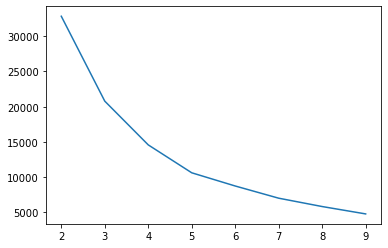

In [90]:
# DETERMINING THE BEST NUMBER OF CLUSTERING LAYERS
# Elbow
withiness = []
ran = range(2,10,1)
for i in range(2,10):
    kmeans = KMeans(n_clusters = i)
    model_elbow = kmeans.fit(X_std_q2)
    withiness.append(model_elbow.inertia_)
    
from matplotlib import pyplot
pyplot.plot(ran,withiness)

In [91]:
# Silhouette
print("Silhouette result")
for i in range(2,10):
    kmeans = KMeans(n_clusters = i)
    model_sil = kmeans.fit(X_std_q2)
    labels = model_sil.labels_
    print("K =",i,":", numpy.average(silhouette_score(X_std_q2, labels)))

Silhouette result
K = 2 : 0.9686575652159152
K = 3 : 0.9697758666613713
K = 4 : 0.9401040081229042
K = 5 : 0.9397815817174344
K = 6 : 0.88804002448831
K = 7 : 0.8915101592600532
K = 8 : 0.8903941511299167
K = 9 : 0.867408931868203


In [93]:
# As suggested by Elbow and Silhouette methods, cluster number k=3 would be optimal
kmeans_q2 = KMeans(n_clusters = 3, random_state = 5)
model_q2 = kmeans_q2.fit(X_std_q2)
labels_q2 = model_q2.predict(X_std_q2)

count = [0, 0, 0]
for j in range(len(labels_q2)):
    if labels_q2[j] == 0:
        count[0] += 1
    elif labels_q2[j] == 1:
        count[1] += 1
    elif labels_q2[j] == 2:
        count[2] += 1

usd_pledged_centre = []
for i in range(3):
    usd_pledged_centre.append(model_q2.cluster_centers_[0][i])
goal_centre = []
for i in range(3):
    goal_centre.append(model_q2.cluster_centers_[1][i])
backers_count_centre = []
for i in range(3):
    backers_count_centre.append(model_q2.cluster_centers_[2][i])
    
cluster_dict = {'Cluster': [1, 2, 3],
       'Number of observations': count,
       'usd_pledged_centre': usd_pledged_centre,
       'goal_centre': goal_centre,
       'backers_count_centre': backers_count_centre}

cluster_df = pd.DataFrame.from_dict(cluster_dict)
#print(cluster_df)

cluster_df

,Cluster,Number of observations,usd_pledged_centre,goal_centre,backers_count_centre
0,1,15614,-0.047698,11.298230,-0.184686
1,2,66,-0.039336,9.317316,-0.150923
2,3,5,-0.016015,0.070463,49.081106
